In [2]:
import numpy as np
import pandas as pd
from matplotlib import pyplot as pl
from IPython.display import clear_output
import json
import random
import time
import torch
import torchvision
import torchvision.transforms as transforms
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

torch.set_grad_enabled(True)
torch.set_printoptions(linewidth=120)

# Estrutura

Diferente do Keras, com o Torch nós temos que montar a estrutura da rede neural, a estrutura de feed forward (previsão) e também a de treinamento.

In [3]:
class MC(nn.Module):
    
    def __init__(self):
        super(MC, self).__init__()
        # definimos as camadas
        self.conv1 = nn.Conv2d(in_channels=1, out_channels=6, kernel_size=5)
        self.conv2 = nn.Conv2d(in_channels=6, out_channels=12, kernel_size=5)
        
        self.fc1 = nn.Linear(in_features=12*4*4, out_features=120)
        self.fc2 = nn.Linear(in_features=120, out_features=60)
        self.out = nn.Linear(in_features=60, out_features=10)
        
        
    # Implementamos o forward pass
    def forward(self,t):
        # 1ª hidden conv layer
        t = F.relu(self.conv1(t))
        t = F.max_pool2d(t, kernel_size=2)
        
        # 2ª hidden conv layer
        t = F.relu(self.conv2(t))
        t = F.max_pool2d(t, kernel_size=2)
        
        # flatten to linear layer
        t = F.relu(self.fc1(t.reshape(-1, 12*4*4)))
        
        # 2ª linear layer
        t = F.relu(self.fc2(t))
        
        # output
        t = self.out(t)
        #t = F.softmax(t, dim=1) #já vamos usar uma função de custo que leva em conta a softmax implicitamente
        return t
    
    
    # treinar normalmente
    # (train_set, batch size, learn rate, epochs, num_processadores, salvar, nome)
    def train(self, t_set, batches, lr, epochs, n_w=0, save=False, name=None):
        train_loader = torch.utils.data.DataLoader(t_set, batch_size=batches, shuffle=True, num_workers=n_w)
        optimizer = optim.Adam(self.parameters(), lr=lr)

        for epoch in range(epochs):
            total_loss = 0
            total_correct = 0

            for batch in train_loader: #define o batch
                ims, las = batch
    
                preds = self(ims) #passa o batch
                loss = F.cross_entropy(preds,las) #calcula o custo
    
                optimizer.zero_grad() #zera o grad anterior
                loss.backward() #calcula o gradiente
                optimizer.step() #atualiza os pesos
    
                total_loss += loss.item()
                total_correct += num_corr(preds,las)
    
            print('Epoch:', epoch, '- Precisão:', total_correct/len(t_set),'- Loss:', total_loss)
        
        if save:
            # salvar parâmetros do modelo
            f_name = f'{name} - accu={np.round(total_correct/len(t_set)*100,2)}'
            torch.save(self.state_dict(), f_name)
    
    
    # onde erra
    def miss(self, t_set, loader):
        N=len(t_set)
        all_preds = torch.Tensor([])
        all_las = torch.tensor([], dtype=torch.int64)
        for batch in loader:
            ims, las = batch

            preds = self(ims)
            all_preds = torch.cat((all_preds,preds),dim=0)
            all_las = torch.cat((all_las,las),dim=0)
       
        all_preds = all_preds.argmax(dim=1).numpy()
        all_las = all_las.numpy()
        
        erros=[] 
        for i in range(N):
            if all_preds[i] != all_las[i]:
                erros.append(t_set[i])
                
        return erros
    

    
# contar acertos
def num_corr(preds,labels):
    return preds.argmax(dim=1).eq(labels).sum().item()

# previsões para todo o set de treino
def get_preds(model, loader):
    all_preds = torch.Tensor([])
    for batch in loader:
        ims, las = batch
        
        preds = model(ims)
        all_preds = torch.cat((all_preds,preds),dim=0)
        
    return all_preds

# plota matriz de confusão
def plot_cm(cm, classes, normalize=False, title='Confusion Matrix', cmap=pl.cm.Blues):
    
    pl.figure(figsize=(8,8))
    pl.imshow(cm, interpolation='nearest', cmap=cmap)
    pl.title(title)
    pl.colorbar()
    tick_marks = np.arange(len(classes))
    pl.xticks(tick_marks, classes, rotation=45)
    pl.yticks(tick_marks, classes)
    
    if normalize:
        cm = cm.astype('float')/cm.sum(axis=1)[:,np.newaxis]
        #print('Normalized Confusion Matrix')
    
    #print(cm)
    
    thresh = cm.max()/2
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        pl.text(j, i, cm[i,j],
               horizontalalignment='center',
               color='white' if cm[i,j]>thresh else 'black')
    
    pl.tight_layout()
    pl.ylabel('True')
    pl.xlabel('Predicted')

# Escrita à mão (MNIST)

Vamos treinar essa rede a identificar dígitos escritos À mão.

In [4]:
# Carregando os dados
train_data = torchvision.datasets.MNIST(
    root='./data/MNIST',
    train=True,
    download=True,
    # transforma os dados num tensor
    transform=transforms.Compose([
        transforms.ToTensor()
    ]))

print(len(train_data)) # nº dados
print(train_data[0][0].shape) # [canais, dim, dim]
print(train_data[5][1])  # labels

60000
torch.Size([1, 28, 28])
2


labels: [4 8 5 2 1 8 6 0 9 5]


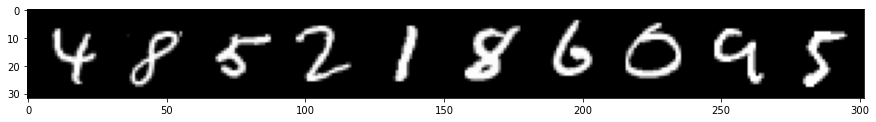

In [5]:
train_loader = torch.utils.data.DataLoader(train_data, batch_size=10, shuffle=True)

# pegar o batch
batch = next(iter(train_loader))
ims, las = batch

# visualizar
grid = torchvision.utils.make_grid(ims, nrow=10)

pl.figure(figsize=(15,15))
pl.imshow(np.transpose(grid, (1,2,0)))
print('labels:', las.numpy())

### Treinar

In [6]:
esc = MC()

In [7]:
# carregar (se já tiver salvo)
esc.load_state_dict(torch.load('.data/Escr - accu=99.0'))

<All keys matched successfully>

In [33]:
# Parâmetros de treino
# (train_set, batch size, learn rate, epochs, num_processadores, salvar, nome)

esc.train(train_data, 250, 0.005, 10, 1, save=True, name='Escr')

Epoch: 0 - Precisão: 0.9003 - Loss: 76.37291346117854
Epoch: 1 - Precisão: 0.9746833333333333 - Loss: 20.35813100077212
Epoch: 2 - Precisão: 0.98105 - Loss: 14.84989542979747
Epoch: 3 - Precisão: 0.98515 - Loss: 11.880776390433311
Epoch: 4 - Precisão: 0.9865833333333334 - Loss: 10.533719452098012
Epoch: 5 - Precisão: 0.9886333333333334 - Loss: 8.685779735911638
Epoch: 6 - Precisão: 0.98885 - Loss: 8.337244329508394
Epoch: 7 - Precisão: 0.9902166666666666 - Loss: 7.163433366920799
Epoch: 8 - Precisão: 0.9916166666666667 - Loss: 6.062878505210392
Epoch: 9 - Precisão: 0.9923833333333333 - Loss: 5.584869187150616


In [9]:
# comparar previsão com realidade
batch = next(iter(train_loader))
ims, las = batch

print('Labes:', las)
print('Predic:', esc(ims).argmax(dim=1))

Labes: tensor([3, 3, 4, 7, 3, 1, 8, 9, 9, 6])
Predic: tensor([3, 3, 4, 7, 3, 1, 8, 9, 9, 6], grad_fn=<NotImplemented>)


### Avaliação

Agora vamos aplicar a avaliação nos dados de teste e checar a precisão do modelo em dados que ele nunca viu antes.

In [52]:
test_data = torchvision.datasets.MNIST(
    root='./data/MNIST',
    train=False,
    download=True,
    transform=transforms.Compose([
        transforms.ToTensor()
    ]))

print(len(test_data)) # nº dados

10000


In [12]:
# desliga a contagem do gradiente localmente para salvar memória
with torch.no_grad():
    pred_loader = torch.utils.data.DataLoader(test_data, batch_size=10000)
    test_preds = get_preds(esc, pred_loader)

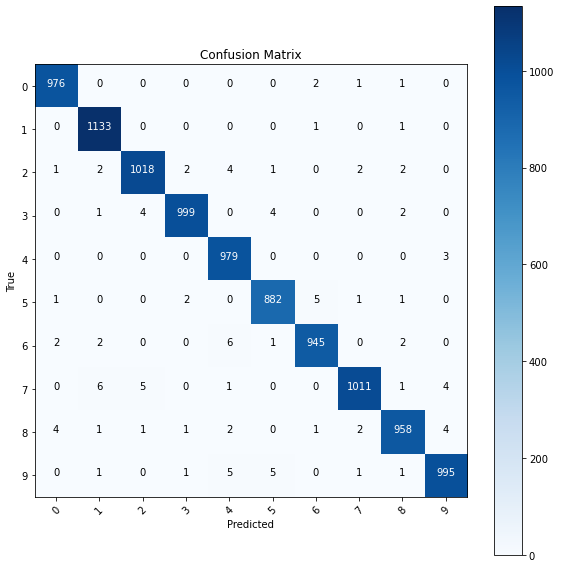

In [13]:
stacked = torch.stack((test_data.targets,test_preds.argmax(dim=1)),dim=1)

cmt = torch.zeros(10,10, dtype=torch.int32)

for p in stacked:
    true, pre = p.tolist()
    cmt[true, pre] = cmt[true, pre] +1
    
cmt = np.array(cmt)

# plotar a matriz de confusão
cm_labels = np.arange(10).tolist()
plot_cm(cmt, cm_labels, title='Confusion Matrix')

labels: [6 0 4 7 8 2 7 1 6 3]
predic: [6 0 4 7 8 2 7 1 6 3]


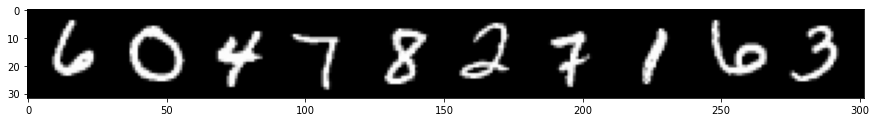

In [15]:
# e visualizar
with torch.no_grad():
    test_loader = torch.utils.data.DataLoader(test_data, batch_size=10, shuffle=True)

    batch = next(iter(test_loader))
    ims, las = batch

    grid = torchvision.utils.make_grid(ims, nrow=10)

    pl.figure(figsize=(15,15))
    pl.imshow(np.transpose(grid, (1,2,0)))
    print('labels:', las.numpy())
    print('predic:', esc(ims).argmax(dim=1).numpy())

In [53]:
# achar onde (e quantas) ele erra
with torch.no_grad():
    loader = torch.utils.data.DataLoader(test_data, batch_size=250)
    
    erros = esc.miss(test_data, loader)
print('Nº erros:', len(erros))
print('Precisão no teste:', (len(test_data)-len(erros))/len(test_data))

Nº erros: 104
Precisão no teste: 0.9896


Labels: [2 6 6 5 8 2 6 7 7 3]
Predic: [3 0 4 0 6 3 8 8 4 5]


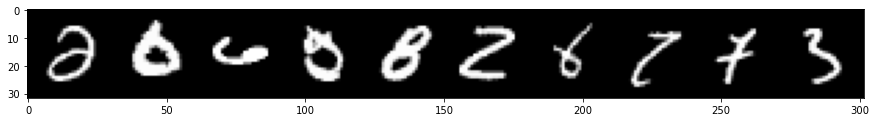

In [18]:
# onde erra
with torch.no_grad():
    # pegue sempre fatias 10 pra ser mais facil de visualisar
    f = 50
    batch = erros[f:f+10]
    ims = torch.Tensor([])
    las = []
    for b, l in batch:
        ims = torch.cat((ims, b.unsqueeze(0)),dim=0)
        las.append(l)

    grid = torchvision.utils.make_grid(ims, nrow=10)

    pl.figure(figsize=(15,15))
    pl.imshow(np.transpose(grid, (1,2,0)))
    print('Labels:', np.array(las))
    print('Predic:', esc(ims).argmax(dim=1).numpy())

Label: 2
Predic: 3


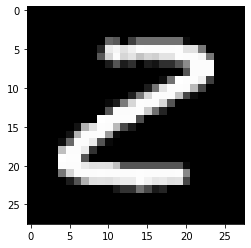

In [19]:
# Achar um erro único
sample = erros[55]
im, la = sample

pl.imshow(im.squeeze(), cmap='gray')
print('Label:', la)
print('Predic:', esc(im.unsqueeze(0)).argmax(dim=1).item()) # previsão pra unica imagem

# Roupas

In [20]:
# pega os dados (baixa se não tiver no local)
train_set = torchvision.datasets.FashionMNIST(
    root='./data/FashionMNIST',
    train=True,
    download=True,
    #transforma os dados num tensor
    transform=transforms.Compose([
        transforms.ToTensor()
    ]))

labels = ['Top','Calça','Pulôver','Vestido','Casaco','Sandalha','Camisa','Tênis','Bolsa','Bota']
len(train_set)

60000

labels: [5 2 1 4 3 0 2 5 4 3]


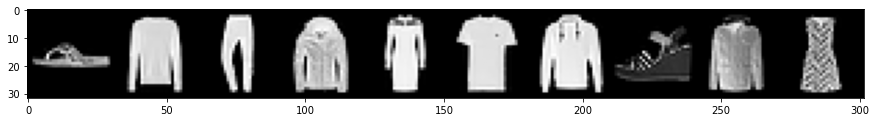

In [21]:
train_loader = torch.utils.data.DataLoader(train_set, batch_size=10, shuffle=True)

batch = next(iter(train_loader))
ims, las = batch

grid = torchvision.utils.make_grid(ims, nrow=10)

pl.figure(figsize=(15,15))
pl.imshow(np.transpose(grid, (1,2,0)))
print('labels:', las.numpy())

### Treinar

In [22]:
vest = MC()

In [23]:
# carregar
vest.load_state_dict(torch.load('.data/Vest - accu=92'))

<All keys matched successfully>

In [57]:
#treinar (train_set, batch size, learn rate, epochs, num_processadores, salvar, nome)
vest.train(train_set, 150, 0.005, 10, 1, save=True, name='Vest')

Epoch: 0 - Precisão: 0.90505 - Loss: 102.26878576725721
Epoch: 1 - Precisão: 0.9085166666666666 - Loss: 97.53870954364538
Epoch: 2 - Precisão: 0.9117833333333333 - Loss: 94.85695893317461
Epoch: 3 - Precisão: 0.91365 - Loss: 92.1983687877655
Epoch: 4 - Precisão: 0.9168833333333334 - Loss: 89.06664264202118
Epoch: 5 - Precisão: 0.9181166666666667 - Loss: 87.0734274238348
Epoch: 6 - Precisão: 0.91965 - Loss: 85.23685702681541
Epoch: 7 - Precisão: 0.9216333333333333 - Loss: 82.44344693422318
Epoch: 8 - Precisão: 0.9242333333333334 - Loss: 80.02002196758986
Epoch: 9 - Precisão: 0.9240833333333334 - Loss: 80.35549546778202


### Avaliação 

In [43]:
test_set = torchvision.datasets.FashionMNIST(
    root='./data/FashionMNIST',
    train=False,
    download=True,
    transform=transforms.Compose([
        transforms.ToTensor()
    ]))

print(len(test_data)) # nº dados

10000


In [44]:
# desliga a contagem do gradiente localmente para salvar memória
with torch.no_grad():
    pred_loader = torch.utils.data.DataLoader(test_set, batch_size=10000)
    test_preds = get_preds(vest,pred_loader)

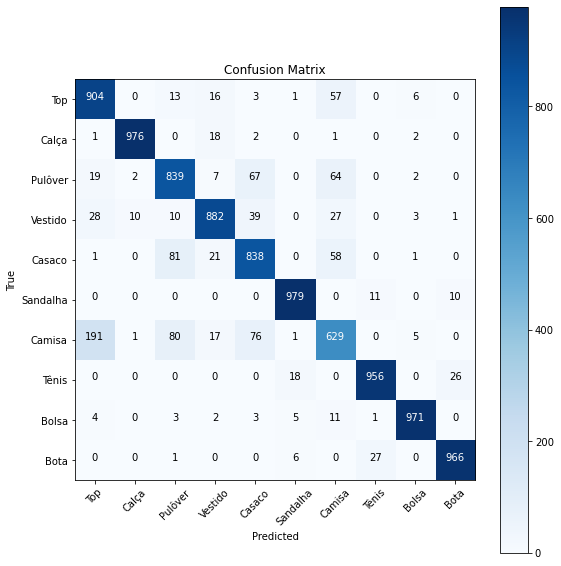

In [45]:
stacked = torch.stack((test_set.targets,test_preds.argmax(dim=1)),dim=1)

cmt = torch.zeros(10,10, dtype=torch.int32)

for p in stacked:
    true, pre = p.tolist()
    cmt[true, pre] = cmt[true, pre] +1
    
cmt = np.array(cmt)

cm_labels = np.arange(10).tolist()
plot_cm(cmt, labels, title='Confusion Matrix')

Dá pra ver que este modelo ainda confunde muito Camisa com Top.

labels: ['Top', 'Bota', 'Bolsa', 'Pulôver', 'Camisa', 'Sandália', 'Sandália', 'Sandália', 'Top', 'Top']
predic: ['Top', 'Bota', 'Bolsa', 'Pulôver', 'Camisa', 'Sandália', 'Sandália', 'Sandália', 'Top', 'Top']


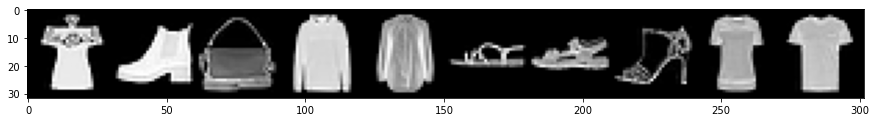

In [55]:
# dicionario pra guardar o que é o quê
dic = {0:'Top',1:'Calça',2:'Pulôver',3:'Vestido',4:'Casaco',5:'Sandália',
      6:'Camisa',7:'Tênis',8:'Bolsa',9:'Bota'}

# testar performance
with torch.no_grad():
    test_loader = torch.utils.data.DataLoader(test_set, batch_size=10, shuffle=True)
    
    batch = next(iter(test_loader))
    ims, las = batch
    
    las = las.numpy()
    las = [dic[x] for x in las]
    pred = vest(ims).argmax(dim=1).numpy()
    pred = [dic[x] for x in pred]

    grid = torchvision.utils.make_grid(ims, nrow=10)

    pl.figure(figsize=(15,15))
    pl.imshow(np.transpose(grid, (1,2,0)))
    print('labels:', las)
    print('predic:', pred)

labels = [0-Top, 1-Calça, 2-Pulôver, 3-Vestido, 4-Casaco, 5-Sandalha, 6-Camisa, 7-Tênis, 8-Bolsa, 9-Bota]

In [50]:
# achar onde (e quantas) ele erra
with torch.no_grad():
    loader = torch.utils.data.DataLoader(test_set, batch_size=250)
    
    erros_v = vest.miss(test_set, loader)
print('Nº erros:', len(erros_v))
print('Precisão no teste:', (len(test_set)-len(erros_v))/len(test_set))

Nº erros: 1060
Precisão no teste: 0.894


Labels: ['Top', 'Camisa', 'Pulôver', 'Camisa', 'Vestido', 'Top', 'Casaco', 'Casaco', 'Top', 'Camisa']
Predic: ['Camisa', 'Top', 'Casaco', 'Top', 'Top', 'Camisa', 'Pulôver', 'Pulôver', 'Camisa', 'Casaco']


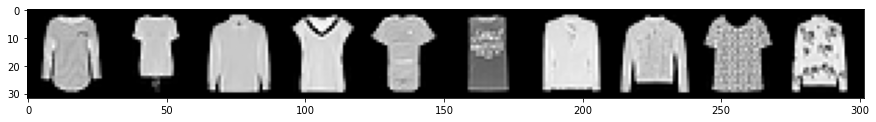

In [56]:
# exemplos de onde erra
with torch.no_grad():
    # pegue sempre fatias 10 pra ser mais facil de visualisar
    f = 100
    batch = erros_v[f:f+10]
    ims = torch.Tensor([])
    las = []
    for b, l in batch:
        ims = torch.cat((ims, b.unsqueeze(0)),dim=0)
        las.append(l)

    las = [dic[x] for x in las]
    pred = vest(ims).argmax(dim=1).numpy()
    pred = [dic[x] for x in pred]
    
    grid = torchvision.utils.make_grid(ims, nrow=10)

    pl.figure(figsize=(15,15))
    pl.imshow(np.transpose(grid, (1,2,0)))
    print('Labels:', las)
    print('Predic:', pred)

Label: Camisa
Predic: Casaco


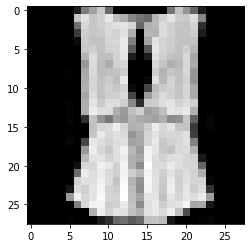

In [61]:
# Exemplo único de onde erra
sample = erros_v[30]
im, la = sample

pl.imshow(im.squeeze(), cmap='gray')
print('Label:', dic[la])
print('Predic:', dic[esc(im.unsqueeze(0)).argmax(dim=1).item()]) # previsão pra unica imagem